**Google Colab Required. Google Colab Pro Preferred.**

In [1]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 2.6 MB 5.0 MB/s 
     |████████████████████████████████| 3.3 MB 35.0 MB/s 
     |████████████████████████████████| 636 kB 33.7 MB/s 
     |████████████████████████████████| 895 kB 46.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 542 kB 5.1 MB/s 
     |████████████████████████████████| 243 kB 10.3 MB/s 
     |████████████████████████████████| 76 kB 4.2 MB/s 
     |████████████████████████████████| 118 kB 10.8 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
root_dir = "gdrive/MyDrive/Capstone/"

pretrained = "funnel-transformer/small-base"
model_checkpoint = pretrained
tokenizer_checkpoint = pretrained

num_labels = 10
batch_size = 16

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AdamW, get_scheduler

import torch
from torch.utils.data import DataLoader

from datasets import load_dataset, load_metric, load_from_disk

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

import pickle
from tqdm.auto import tqdm

In [5]:
dataset = load_dataset('csv', data_files=root_dir + 'df_cleaned.csv', split='train')

Using custom data configuration default-863e501dda6703d2


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-863e501dda6703d2/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


In [6]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)

def tokenize_function(examples):
    return tokenizer(examples["tweet_text_cleaned"], padding="max_length", truncation=True)

tokenized_datasets = dataset.train_test_split(test_size=0.1).map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/153 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/704 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/153 [00:00<?, ?B/s]

  0%|          | 0/69 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

In [7]:
tokenized_datasets = tokenized_datasets.remove_columns(['class_label', 
                                                        'data_type', 
                                                        'event',
                                                        'event_type',
                                                        'file_name',
                                                        'hashtags',
                                                        'processed_text_length',
                                                        #'token_type_ids',
                                                        'tweet_id',
                                                        'tweet_text',
                                                        'tweet_text_cleaned',
                                                        'year'])
tokenized_datasets = tokenized_datasets.rename_column("class_label_id", "labels")
tokenized_datasets.set_format("torch")

In [8]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=batch_size)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=batch_size)

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Downloading:   0%|          | 0.00/462M [00:00<?, ?B/s]

Some weights of FunnelForSequenceClassification were not initialized from the model checkpoint at funnel-transformer/small-base and are newly initialized: ['classifier.linear_hidden.bias', 'classifier.linear_out.weight', 'classifier.linear_out.bias', 'classifier.linear_hidden.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FunnelForSequenceClassification(
  (funnel): FunnelBaseModel(
    (embeddings): FunnelEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (layer_norm): LayerNorm((768,), eps=1e-09, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): FunnelEncoder(
      (attention_structure): FunnelAttentionStructure(
        (sin_dropout): Dropout(p=0.1, inplace=False)
        (cos_dropout): Dropout(p=0.1, inplace=False)
      )
      (blocks): ModuleList(
        (0): ModuleList(
          (0): FunnelLayer(
            (attention): FunnelRelMultiheadAttention(
              (hidden_dropout): Dropout(p=0.1, inplace=False)
              (attention_dropout): Dropout(p=0.1, inplace=False)
              (q_head): Linear(in_features=768, out_features=768, bias=False)
              (k_head): Linear(in_features=768, out_features=768, bias=True)
              (v_head): Linear(in_features=768, out_features=768, bias=True)
              (post_proj): Linear(i

In [10]:
device

device(type='cuda')

In [11]:
optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [12]:
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/189 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [13]:
metric= load_metric("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

{'accuracy': 0.669}

In [14]:
metric_name = "accuracy"

args = TrainingArguments(
    "capstone_"+pretrained,
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    metric_for_best_model=metric_name,
)

In [15]:
metric= load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [16]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [17]:
trainer.train()

***** Running training *****
  Num examples = 68834
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 12909


Epoch,Training Loss,Validation Loss,Accuracy
1,0.702400,0.711486,0.753170
2,0.579800,0.665621,0.766505
3,0.475500,0.691582,0.766375


Saving model checkpoint to capstone_funnel-transformer/small-base/checkpoint-500
Configuration saved in capstone_funnel-transformer/small-base/checkpoint-500/config.json
Model weights saved in capstone_funnel-transformer/small-base/checkpoint-500/pytorch_model.bin
tokenizer config file saved in capstone_funnel-transformer/small-base/checkpoint-500/tokenizer_config.json
Special tokens file saved in capstone_funnel-transformer/small-base/checkpoint-500/special_tokens_map.json
Saving model checkpoint to capstone_funnel-transformer/small-base/checkpoint-1000
Configuration saved in capstone_funnel-transformer/small-base/checkpoint-1000/config.json
Model weights saved in capstone_funnel-transformer/small-base/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in capstone_funnel-transformer/small-base/checkpoint-1000/tokenizer_config.json
Special tokens file saved in capstone_funnel-transformer/small-base/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to capstone_f

TrainOutput(global_step=12909, training_loss=0.6146296829837105, metrics={'train_runtime': 10455.4627, 'train_samples_per_second': 19.751, 'train_steps_per_second': 1.235, 'total_flos': 5.88502765334569e+16, 'train_loss': 0.6146296829837105, 'epoch': 3.0})

In [18]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 7649
  Batch size = 16


{'epoch': 3.0,
 'eval_accuracy': 0.7663746895018957,
 'eval_loss': 0.691582202911377,
 'eval_runtime': 122.514,
 'eval_samples_per_second': 62.434,
 'eval_steps_per_second': 3.91}

In [19]:
model.save_pretrained(root_dir + 'models/' + pretrained)
tokenizer.save_pretrained(root_dir + 'tokenizers/' + pretrained)

Configuration saved in gdrive/MyDrive/Capstone/models/funnel-transformer/small-base/config.json
Model weights saved in gdrive/MyDrive/Capstone/models/funnel-transformer/small-base/pytorch_model.bin
tokenizer config file saved in gdrive/MyDrive/Capstone/tokenizers/funnel-transformer/small-base/tokenizer_config.json
Special tokens file saved in gdrive/MyDrive/Capstone/tokenizers/funnel-transformer/small-base/special_tokens_map.json


('gdrive/MyDrive/Capstone/tokenizers/funnel-transformer/small-base/tokenizer_config.json',
 'gdrive/MyDrive/Capstone/tokenizers/funnel-transformer/small-base/special_tokens_map.json',
 'gdrive/MyDrive/Capstone/tokenizers/funnel-transformer/small-base/vocab.txt',
 'gdrive/MyDrive/Capstone/tokenizers/funnel-transformer/small-base/added_tokens.json',
 'gdrive/MyDrive/Capstone/tokenizers/funnel-transformer/small-base/tokenizer.json')

In [20]:
tokenized_datasets.save_to_disk(root_dir + 'assets/datasets/' + pretrained)

# Results Visualization

In [21]:
dataset = load_dataset('csv', data_files=root_dir + 'df_cleaned.csv', split='train')
tokenized_datasets = load_from_disk(root_dir + 'assets/datasets/' + pretrained)
tokenized_datasets.set_format("torch")

Using custom data configuration default-863e501dda6703d2
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-863e501dda6703d2/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)


In [22]:
model_checkpoint = root_dir + "models/" + pretrained
tokenizer_checkpoint = root_dir + "tokenizers/" + pretrained

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=10)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

loading configuration file gdrive/MyDrive/Capstone/models/funnel-transformer/small-base/config.json
Model config FunnelConfig {
  "_name_or_path": "funnel-transformer/small-base",
  "activation_dropout": 0.0,
  "architectures": [
    "FunnelForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "attention_type": "relative_shift",
  "block_repeats": [
    1,
    1,
    1
  ],
  "block_sizes": [
    4,
    4,
    4
  ],
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "hidden_act": "gelu_new",
  "hidden_dropout": 0.1,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.1,
  "initializer_std": null,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9

FunnelForSequenceClassification(
  (funnel): FunnelBaseModel(
    (embeddings): FunnelEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (layer_norm): LayerNorm((768,), eps=1e-09, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): FunnelEncoder(
      (attention_structure): FunnelAttentionStructure(
        (sin_dropout): Dropout(p=0.1, inplace=False)
        (cos_dropout): Dropout(p=0.1, inplace=False)
      )
      (blocks): ModuleList(
        (0): ModuleList(
          (0): FunnelLayer(
            (attention): FunnelRelMultiheadAttention(
              (hidden_dropout): Dropout(p=0.1, inplace=False)
              (attention_dropout): Dropout(p=0.1, inplace=False)
              (q_head): Linear(in_features=768, out_features=768, bias=False)
              (k_head): Linear(in_features=768, out_features=768, bias=True)
              (v_head): Linear(in_features=768, out_features=768, bias=True)
              (post_proj): Linear(i

In [23]:
device

device(type='cuda')

In [24]:
metric = load_metric("accuracy")
eval_dataloader = DataLoader(tokenized_datasets["test"], batch_size=batch_size)

model.eval()
#prob = []
y_pred = []
total_loss = 0.0
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    total_loss += outputs.loss.item()
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])
    #prob.extend(torch.nn.Softmax(dim=1)(outputs.logits))
    y_pred.extend([t.item() for t in predictions])

loss = total_loss/tokenized_datasets["test"].shape[0]
metric.compute()

{'accuracy': 0.7663746895018957}

In [25]:
loss

0.04324931837447891

In [26]:
y_true = tokenized_datasets["test"]["labels"].numpy().tolist()

In [27]:
assert len(y_true) == len(y_pred)

In [28]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, path='cm', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     pickle.dump(cm, open(path, 'wb'))

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [29]:
label_name = sorted(pd.Series(dataset['class_label']).unique())

loss: 0.04
accuracy: 0.77
matthews coef: 0.72
precision score for caution_and_advice: 0.87
recall score for caution_and_advice: 0.88
f1 score for caution_and_advice: 0.88
precision score for displaced_people_and_evacuations: 0.62
recall score for displaced_people_and_evacuations: 0.55
f1 score for displaced_people_and_evacuations: 0.58
precision score for infrastructure_and_utility_damage: 0.91
recall score for infrastructure_and_utility_damage: 0.94
f1 score for infrastructure_and_utility_damage: 0.93
precision score for injured_or_dead_people: 0.78
recall score for injured_or_dead_people: 0.83
f1 score for injured_or_dead_people: 0.80
precision score for missing_or_found_people: 0.58
recall score for missing_or_found_people: 0.47
f1 score for missing_or_found_people: 0.52
precision score for not_humanitarian: 0.83
recall score for not_humanitarian: 0.91
f1 score for not_humanitarian: 0.87
precision score for other_relevant_information: 0.84
recall score for other_relevant_information

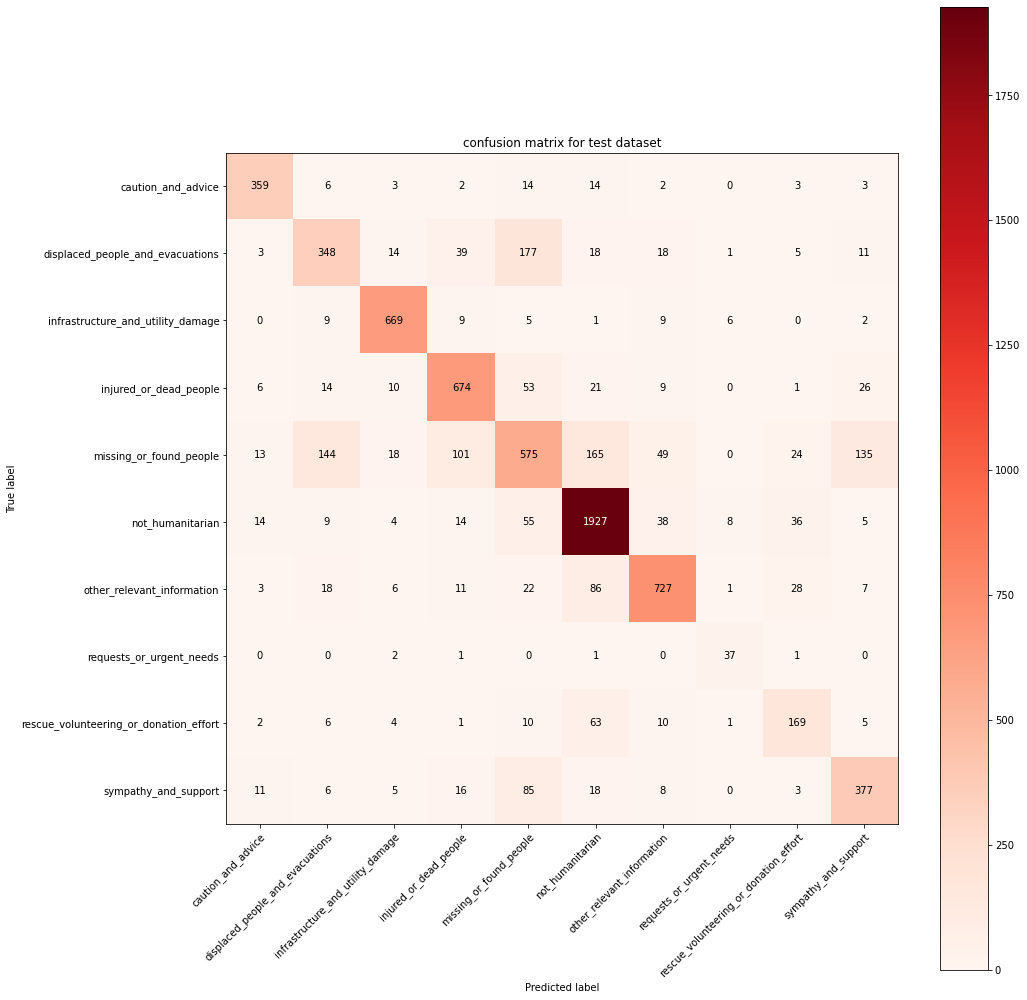

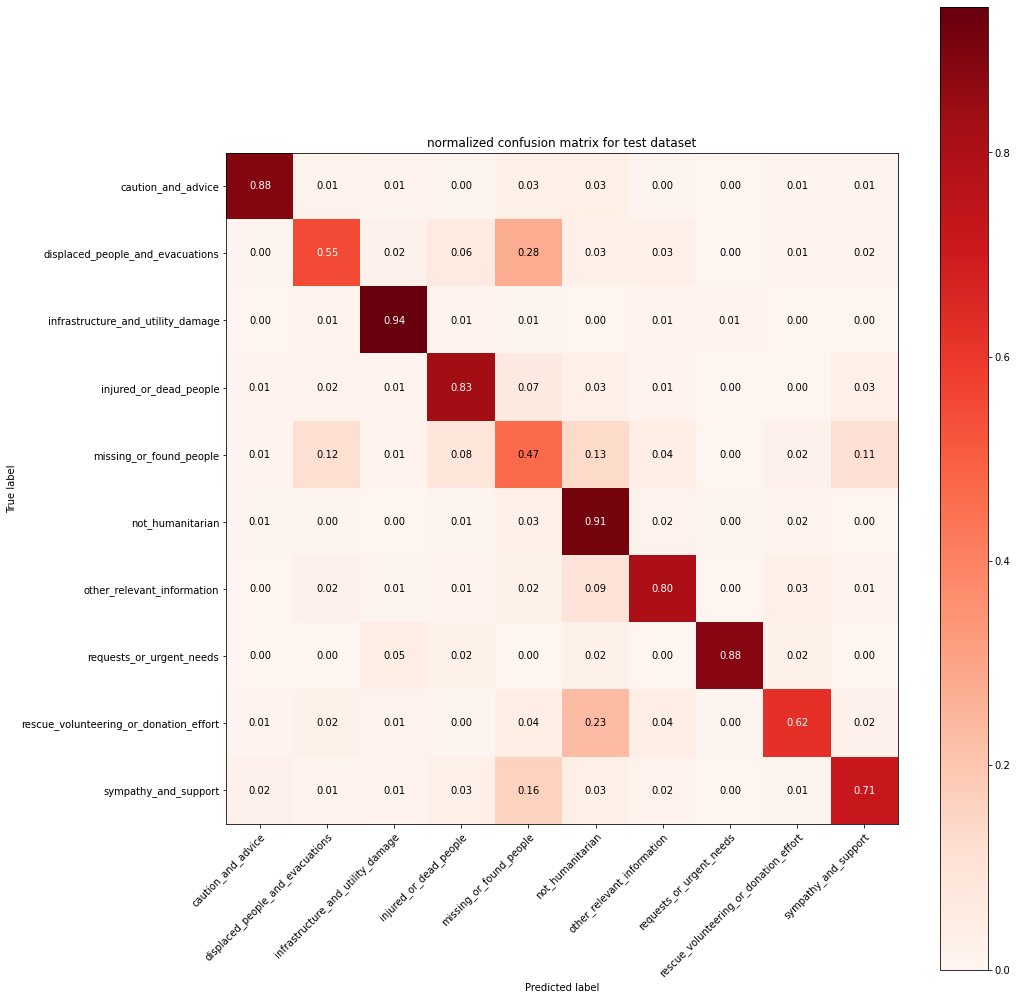

In [32]:
accuracy = accuracy_score(y_true, y_pred)
matthews = matthews_corrcoef(y_true, y_pred)

precisions = {}
recalls = {}
f1s = {}
aucrocs = {}

for i in range(len(label_name)):
    prediction_ = [1 if pred == i else 0 for pred in y_pred]
    true_ = [1 if label == i else 0 for label in y_true]
    f1s.update({label_name[i]: f1_score(true_, prediction_)})
    precisions.update({label_name[i]: precision_score(true_, prediction_)})
    recalls.update({label_name[i]: recall_score(true_, prediction_)})
    # aucrocs.update({label_name[i]: roc_auc_score(true_, list(t.item() for t in prob[:, i]))})

metrics_dict = {'loss': loss, 'accuracy': accuracy, 'matthews coef': matthews, 'precision': precisions,
                     'recall': recalls, 'f1': f1s, 
                # 'aucroc': aucrocs
                }

pickle.dump(metrics_dict, open(root_dir+'/output/evaluation_metrics/'+pretrained, 'wb'))

cm = plot_confusion_matrix(y_true, y_pred, label_name, normalize=False,
                      path='test_confusion_matrix', title='confusion matrix for test dataset')
plt.savefig(root_dir+'/output/confusion_matrix/'+pretrained, format='png')
cm_norm = plot_confusion_matrix(y_true, y_pred, label_name, normalize=True,
                      path='test normalized_confusion_matrix', title='normalized confusion matrix for test dataset')
plt.savefig(root_dir+'/output/normalized_confusion_matrix/'+pretrained, format='png')

print('loss: %.2f' % loss)
print('accuracy: %.2f' % accuracy)
print('matthews coef: %.2f' % matthews)
for i in range(len(label_name)):
    print('precision score for %s: %.2f' % (label_name[i], precisions[label_name[i]]))
    print('recall score for %s: %.2f' % (label_name[i], recalls[label_name[i]]))
    print('f1 score for %s: %.2f' % (label_name[i], f1s[label_name[i]]))
    # print('auc roc score for %s: %.2f' % (label_name[i], aucrocs[label_name[i]]))

In [ ]:
with open(root_dir+'/output/evaluation_metrics/'+pretrained, 'rb') as file:
    p = pickle.load(file)